Task 4: Word-level LSTM RNN 

In [1]:

import numpy as np
%matplotlib inline
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

In [2]:
#Reading the 3 text files 

file = open("Text1.txt","r")
if(file.mode == "r"):
    text1 = file.read()
file.close()

file = open("Text2.txt","r")
if(file.mode == "r"):
    text2 = file.read()
file.close()

file = open("Text3.txt","r")
if(file.mode == "r"):
    text3 = file.read()
file.close()


In [3]:
#Concatenating the 3 texts
data = text1+text2+text3

#Converting upper case to lower case
data = data.lower()

In [4]:
# Remove all the special characters

data = data.replace("\n"," ")
data = data.replace("*","")
data = re.sub(r'[^a-zA-Z0-9_\s]+', '', data)

In [5]:
#Creating char_to_index and index_to_char vectors.
data = nltk.word_tokenize(data)
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 351569 characters, 16317 unique


In [6]:
#Constants and Hyperparameters
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 0.5 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [7]:
#Activation Functions and derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [8]:
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad

In [9]:
#We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
#and (0.5, weight_sd) for  sigmoid  activation function.

#Biases are initialized to zeros.

class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [10]:
#Forward Propagation
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [11]:
#Backward Propagation
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [12]:
#Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [13]:
#Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [14]:
#Calculate and store the values in forward pass. 
#Accumulate gradients in backward pass and clip gradients to avoid exploding gradients.

def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [15]:
#Function to generate next character
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [16]:
#Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = sample(h_prev, C_prev, inputs[0], 20)
    txt = ' '.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    # display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [17]:
#update the parameters 
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [18]:
#To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [19]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

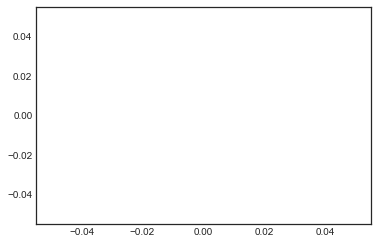

----
 vibration swiftly bubbling coolheaded skeletonsand dens youhave curse unoccupiedthose selfcomposed quarries notwithstanding rode offence pheasant lasted fireeating enclosing exclaiming joys 
----
iter 0, loss 242.498649


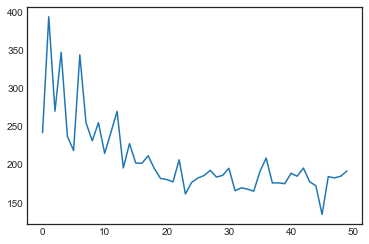

----
 atvaar had ammunition it of disasters air although the at enacted surface typhoons of visible of waves by than car 
----
iter 50, loss 240.678942


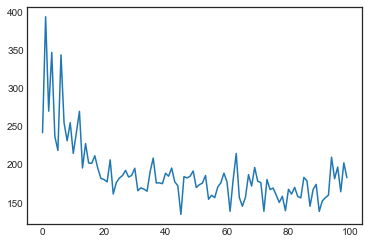

----
 to island loud able its vast furious cooler to cost us save save master were escaped that giddy at not 
----
iter 100, loss 237.183080


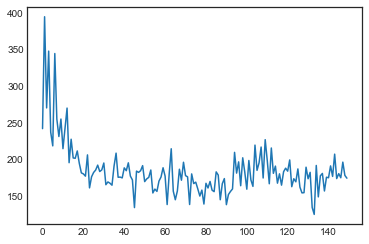

----
 by sea had the acrobatic jaws the overboard liver pickaxe one voyagers this that journal times kiounis it were man 
----
iter 150, loss 234.378988


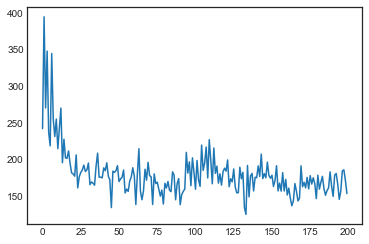

----
 men at rusty the captain date asked membrane and his master personified to a and use his predict history well 
----
iter 200, loss 230.975716


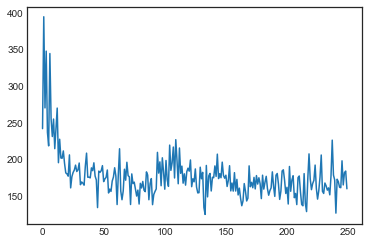

----
 the northeast stand that for neither himself the point which the north of the southerly of the neither all is 
----
iter 250, loss 227.822834


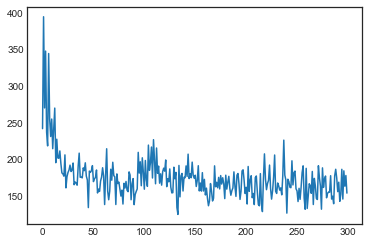

----
 the engineer august on the night the net rise at panting still the eyes of a had able to the 
----
iter 300, loss 224.577766


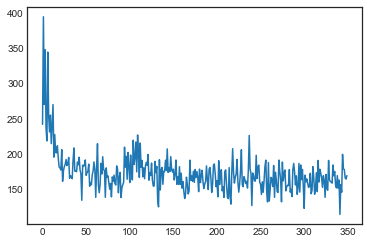

----
 but if five whether the place those the remaining and result and over see their feet was a they this 
----
iter 350, loss 221.599911


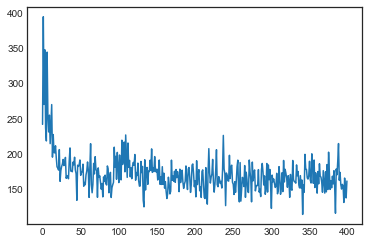

----
 the heart thought phase the left of important point island round particulars this cried appeared length and from let us 
----
iter 400, loss 218.810183


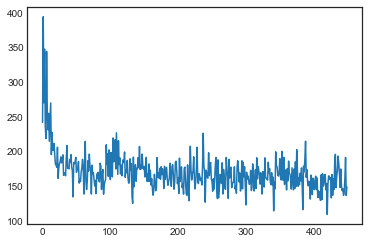

----
 replied replied aspect to a the the to august sailors the sailor thought we up here was for castaways to 
----
iter 450, loss 215.724319
SIGINT received. Delaying KeyboardInterrupt.


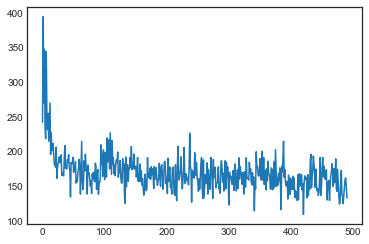

----
 i water or ocean his slope to absorbing his in nor the cliff freshly on them of the crucible by 
----
iter 491, loss 213.359999


In [20]:
#Training loop
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 50 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

In [21]:
# Print generated text from random input character

sample_idx = sample(g_h_prev, g_C_prev, inputs[0], 50)
txt = ' '.join(idx_to_char[idx] for idx in sample_idx)

print(txt)

a point but had or oblique its diplomatic to be too anyone the ranges the bank was not to the box was their box of a thought it not the left in the time almost almost when reconnoitered cold know they were well in all a for rays a cave


In [22]:
from random import uniform
#Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [23]:
#Check gradient of each paramter matrix/vector at num_checks individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                                                     target,
                                                     h_prev, C_prev)
            grad_analytical = d_copy.flat[rnd_idx]

            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [24]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_v (-2.457767e-06, -2.457692e-06) => 1.534891e-05
W_v (-7.101661e-05, -7.101615e-05) => 3.268021e-06
W_v (1.016147e-05, 1.016038e-05) => 5.372922e-05
W_v (1.286082e-07, 1.286001e-07) => 3.153118e-05
W_v (-3.354543e-04, -3.354535e-04) => 1.247444e-06
W_v (-7.474910e-07, -7.480944e-07) => 4.031857e-04
W_v (-8.029133e-08, -8.053172e-08) => 1.485511e-03
W_v (2.749800e-06, 2.750345e-06) => 9.894796e-05
W_v (-4.241940e-07, -4.246933e-07) => 5.874403e-04
b_v (3.735039e-05, 3.734988e-05) => 6.846767e-06
b_v (1.248424e-05, 1.248541e-05) => 4.720858e-05
b_v (4.963141e-05, 4.963192e-05) => 5.131530e-06
b_v (9.099139e-05, 9.099241e-05) => 5.599456e-06
b_v (1.990514e-05, 1.990543e-05) => 7.303969e-06
b_v (4.061178e-05, 4.061240e-05) => 7.583336e-06
b_v (2.231957e-05, 2.232043e-05) => 1.919064e-05
b_v (3.751168e-05, 3.751343e-05) => 2.326205e-05
b_v (1.437286e-05, 1.437325e-05) => 1.346167e-05
